In [1]:
import glob
import os
import pandas as pd
import argparse
import subprocess
import re
from IPython.core import display as ICD
from os import listdir
from multiprocessing import cpu_count
from multiprocessing import Pool
from shutil import rmtree
from subprocess import check_output

# Timeseries Pull & Averaging

## Table of Conents:

* [Get Input Data](#input)
* [Transform functionals with flirt and fslmath](#transform)
* [Pull individual ROI timeseries by subject](#pulltimeseries)


Steps:
1. Pull *uncorrected* timeseries from functionals  
2. Create functional connectivity matrices(FCMs) for each subject per run 
3. Average the FCMs across runs

In [2]:
# load and set variables
data_path='/projects/niblab/experiments/chocolate_milkshake/data'
beta_path='/projects/niblab/experiments/chocolate_milkshake/data/betaseries'
concat_path="/projects/niblab/experiments/chocolate_milkshake/data/betaseries/concat_niftis"
subject_folders=sorted(glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/preprocessed/sub-*'))

data_dict={}
bad_subs=[]


In [3]:
"""
# Helper Functions
#
"""

def chunks(l,n):
    return [l[i:i+n] for i in range(0, len(l), n)]


In [4]:
# get functionals 
subjects=glob.glob(os.path.join(data_path, "preprocessed/sub-*/ses-1"))
print("Subjects found: {}".format(len(subjects)))

functional_niis=glob.glob(os.path.join(data_path, "preprocessed/sub-*/ses-1/func/*brain.nii.gz"))
print("Functional nifti files found: {}".format(len(functional_niis)))



Subjects found: 115
Functional nifti files found: 343


In [5]:
for func_file in functional_niis:
    #print(func_file.split("/")[-1])
    subj_id = func_file.split("/")[-1].split("_")[0]
    task_id = func_file.split("/")[-1].split("_")[2]
   # print(subj_id, task_id)
    if 'imagine' in task_id:
        pass
    else:
        if subj_id not in data_dict:
            data_dict[subj_id]={}
        if task_id not in data_dict[subj_id]:
            data_dict[subj_id][task_id]={}


print("[INFO] Dictionary made, {} keys".format(len(data_dict.keys())))

[INFO] Dictionary made, 115 keys


## Transform nifti <a class='anchor' id='transform'></a>

In [15]:
def tranform_niftis(niftis, verbose=False, run_process=False):
    reference_nifti='/projects/niblab/parcellations/chocolate_decoding_rois/mni2ace.nii.gz'
    reference_mat='/projects/niblab/parcellations/chocolate_decoding_rois/mni2ace.mat'
    for nii in niftis:

        # setup and run flirt
        nii=nii.replace('.nii.gz', '')
        out=nii+'_3mm'
        
        # flirt command
        flirt_cmd="flirt -in {} -ref {} -init {} -applyxfm -out {}".format(nii, reference_nifti, reference_mat, out)
        if verbose != False:
            print('[INFO] flirt command: \n{}'.format(flirt_cmd))
        if run_process == True:
            os.system(flirt_cmd)

        # fslmaths command to threshold --use binary option for transforming masks
        fslmaths_cmd='fslmaths {} -thr 0.9 {}'.format(out,out)
        if verbose != False:
            print('[INFO] fslmaths command: \n{}'.format(fslmaths_cmd))
        if run_process == True:
            os.system(fslmaths_cmd)

In [16]:

print('[INFO] transform functionals to match the mask.')
chunksize=10
funcs=functional_niis

# grab concatenated (fslmerge) data
#fslmerged_files[:4]
print("[INFO] chunksize: {}".format(chunksize))
chunk_list=chunks(funcs, chunksize)
#print(len(chunk_list))
with Pool(12) as p:
    p.map(tranform_niftis, chunk_list)
print('[INFO] transformation process complete.')


[INFO] transform functionals to match the mask.
[INFO] chunksize: 10
[INFO] transformation process complete.


## Pull Timeseries <a class='anchor' id='pulltimeseries'></a>
  
  
**Pull individual ROI timeseries from the bigbrain300 atlas for each subject per condition**. 

Example command:  


    fslmeants -i ~/sub-001_punish.nii.gz -o ~/3_pull_timeseries/sub-001_punish_AI_35_23_-6_asymPREPspace.nii.gz.txt -m ~/AI_35_23_-6_asymPREPspace.nii.gz



In [31]:


def pull_timeseries(file_list, bb300_path='/projects/niblab/parcellations/bigbrain300',roi_df='/projects/niblab/parcellations/bigbrain300/renaming.csv'):

    
    bad_subs=[]
    #ICD.display(roi_df)

    # load asymmetrical nifti roi files
    asym_niftis=glob.glob("/projects/niblab/parcellations/bigbrain300/MNI152Asymmetrical_3mm/*.nii.gz")

    # load roi list
    out_dir = os.path.join(data_path, 'rois/bigbrain300/funcs_uc')
    #print('[INFO] output folder: \t%s \n'%out_dir)


    # loop through the roi file list
    #print(roi_list[:3])
    for nifti in sorted(file_list):

        subj_id = nifti.split("/")[-1].split("_")[0]
        task_id = nifti.split("/")[-1].split("_")[2]
        #print('[INFO] roi: %s %s \n%s'%(subj_id, task_id, nifti))

        # loop through roi reference list
        for ref_nifti in sorted(asym_niftis):
            #print('[INFO] reference roi: %s'%ref_nifti)
            roi = ref_nifti.split('/')[-1].split(".")[0]
            out_path = os.path.join(out_dir, "{}_{}_{}_{}.txt".format(subj_id, "ses-1", task_id, roi))
            #print(roi, out_path)
            cmd='fslmeants -i {} -o {} -m {}'.format(nifti, out_path, ref_nifti)
            try:
                #cmd='fslmeants -i {} -o {} -m {}'.format(nifti, out_path, ref_nifti)
                print("Running shell command: {}".format(cmd))
                #os.system(cmd)
                pass
            except:
                bad_subs.append((subj_id, task_id))
        
        #print('[INFO] finished processing for %s'%subj_id)
        

    return "%s"%bad_subs

   

In [37]:

# load roi
print("[INFO] loading roi and reference file....")

#subject_ids=[x.split("/")[-2] for x in glob.glob(os.path.join(data_path, 'preprocessed/sub-*/ses-1'))]
# get functionals 
funcs_3mm =glob.glob(os.path.join(data_path, "preprocessed/sub-*/ses-1/func/*milkshake*brain_3mm.nii.gz"))
print("Functional nifti files found: {}".format(len(funcs_3mm)))
chunksize=16
print("[INFO] chunksize: {}".format(chunksize))
chunk_list=chunks(funcs_3mm, chunksize)
#roi_df['network']
# pull timeseries by rois --fslmeants command
#print(chunk_list)
def run_process(pool_size):
    print("[INFO] starting multiprocess...")
    with Pool(pool_size) as p:
        error_subjects=p.map(pull_timeseries, chunk_list)
    print("[INFO] process complete. \n[INFO] bad subjects: \t\t%s"%error_subjects)
    
pool_size=16
#run_process(pool_size)

[INFO] loading roi and reference file....
Functional nifti files found: 229
[INFO] chunksize: 16


In [39]:

!sbatch /projects/niblab/experiments/chocolate_milkshake/data/code/uc_ts_pull.job

Submitted batch job 3305433


In [6]:
!squeue -j 3305425
#!scancel 3305433 
#!squeue -u nbytes

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           3305425     batch timeseri   nbytes  R   21:09:55      1 largemem-0-0


In [46]:
!ls /projects/niblab/experiments/chocolate_milkshake/data/error_files

timepull_beta_err_3185250.txt  timepull_out_3185250.txt
timepull_beta_err_3185251.txt  timepull_out_3185251.txt
timepull_beta_err_3185254.txt  timepull_out_3185254.txt
timepull_beta_err_3185256.txt  timepull_out_3185256.txt
timepull_beta_err_3185257.txt  timepull_out_3185257.txt
timepull_err_3305301.txt       timepull_out_3305301.txt


In [48]:
!cat /projects/niblab/experiments/chocolate_milkshake/data/error_files/timepull_err_3305301.txt

  File "/projects/niblab/experiments/chocolate_milkshake/data/code/uc_ts_pull.py", line 79
    """  
        ^
IndentationError: unindent does not match any outer indentation level


## Combine Timeseries<a class='anchor' id='combinetimeseries'></a>

**Combine individual rois for each subject and condition into a single matrix**

In [13]:
# Check for subjects with all 300 regions pulled
# save the roi ct in the dictionary under tag 'bb300'

for subject in data_dict.keys():
    for task in data_dict[subject].keys():
        task_files=glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/rois/bigbrain300/funcs_uc/*%s*%s*.txt'%(subject, task))
        data_dict[subject][task]['bb300'] = len(task_files)
            
subs_in_matrices=[z.split("/")[-1].split("_")[0] for z in glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/rois/bigbrain300/funcs_uc/*.txt')]

unique_subs_rois_id= set(subs_in_matrices)

    



In [14]:
print("[INFO] %s subjects have complete 300 individual roi pulls"%len(unique_subs_rois_id))



[INFO] 53 subjects have complete 300 individual roi pulls


In [15]:
error_subjects=[]
def timeseries_concat(subject_id, task,verbose=True, run_process=False):
    
    #for subject_id in subject_ids:
        
        #tasks=list(data_dict[subject_id].keys())
        
        #for task in tasks:
            

        #print(subject_id, task, stim)
        #print(os.path.join(beta_path, 'rois/big300/%s'%stim))
        # get roi texts for subject / condition
        roi_files = glob.glob(os.path.join(data_path, 'rois/bigbrain300/funcs_uc/%s*%s*.txt'%(subject_id,task)))

        df_lst=[]
        #print(roi_files)


        try:
            for txt in roi_files: 
                #print(txt)
                df_temp = pd.read_csv(txt, sep="\n", header=None)
                #print(df_temp)
                df_lst.append(df_temp)
            #print(subject_id, task, len(df_lst))

            df_concat= pd.concat(df_lst, axis=1, sort=False)
            #print(df_concat)

            # write output file 

            if not os.path.exists(os.path.join(data_path,'subject_matrices/funcs_uc')):
                if verbose==True:
                    print('[INFO] making ',os.path.join(data_path,'subject_matrices/funcs_uc'))

                #os.makedirs(os.path.join(beta_path,'subject_matrices/%s'%stim))
            outfile=os.path.join(data_path, 'subject_matrices/funcs_uc/%s_ses-1_%s.txt'%(subject_id,task))
            if verbose==True:
                print('[PROCESSING] making file %s....'%outfile)
            if run_process ==True:
                df_concat.to_csv(outfile, header=None, index=None, sep='\t')
        except:
            pass
            error_subjects.append((subject_id,task))

        #if error_subjects: print(error_subjects)
        return error_subjects;


    
    

## Functional Connectivity Matrix <a class='anchor' id='fcm'></a>

In [16]:
import seaborn as sns
from nilearn.connectome import ConnectivityMeasure
import numpy as np
from matplotlib import pyplot as plt
from nilearn import plotting
from nilearn.plotting import plot_connectome


In [94]:

"""
# Helper Functions
"""

   
def make_subject_fcm(subj_id, save_files=True, heatmap=False, connectome=False,verbose=True):
    
    if subj_id not in fc_corr_dict:
        fc_corr_dict[subj_id] = {}

    if subj_id not in subj_list:
        subj_list.append(subj_id)
            
    roi_matrices =glob.glob(os.path.join(data_path, 'subject_matrices/funcs_uc/%s*.txt'%subj_id))

    for matrix in roi_matrices:
        
        filename = matrix.split("/")[-1] #"%s_ses-1_%s.txt"%(subj_id, task_id)
        #print("\n[INFO] Subject Matrix: %s "%filename)
        
        title_str=filename.split(".")[0]

        try:
            # we load the text file timeseries into an array 
            np_arr = np.loadtxt(matrix)
            #print(np_arr)


            # call fit_transform from ConnectivityMeasure object
            correlation_matrix = connectome_measure.fit_transform([np_arr])#[0]
            correlations.append(correlation_matrix)
            #print('[INFO] CORRELATION: ', correlation_matrix.shape)
            
            # Mask out the major diagonal
            np.fill_diagonal(correlation_matrix, 0)
            outfile=os.path.join(data_path, 'fcms/subjects/%s'%filename)

            if heatmap==True:
                # plot subject correlation matrix
                plotting.plot_matrix(correlation_matrix, cmap=cmap, colorbar=True,title=title_str, tri='lower')
            
            if connectome==True:
                # We threshold to keep only the 20% of edges with the highest value
                # because the graph is very dense
                plotting.plot_connectome(correlation_matrix, coords_list, edge_threshold="90%", title=title_str)

            # do I save the files?
            if save_files==True:
                # save correlation as textfile
                np.savetxt(outfile, correlation_matrix.transpose(2,0,1).reshape(3,-1))
                if verbose==True:
                    print("[INFO] Outfile: {}".format(outfile))
            
            
        except:
            bad_subjects.append(subj_id)
            pass
    #print("[INFO] completed process")


Load coordinate file:

In [95]:

coords_df=pd.read_csv('/projects/niblab/parcellations/bigbrain300/BigBrain300_MNI_coordinates.txt',sep='\t',header=None)

coords_list=[]
for index, row in coords_df.iterrows():
    #print(row[0],row[1],row[2])
    coords_list.append((row[0],row[1],row[2]))
    
len(coords_list)

300

In [96]:
print("[INFO] %s timeseries matrices files"%len(
    listdir(os.path.join(data_path, 'subject_matrices/funcs_uc'))))
      
      

[INFO] 45 timeseries matrices files



[INFO] sub-001 correlation between 300 regions, conditions milkshakeC and milkshakeB


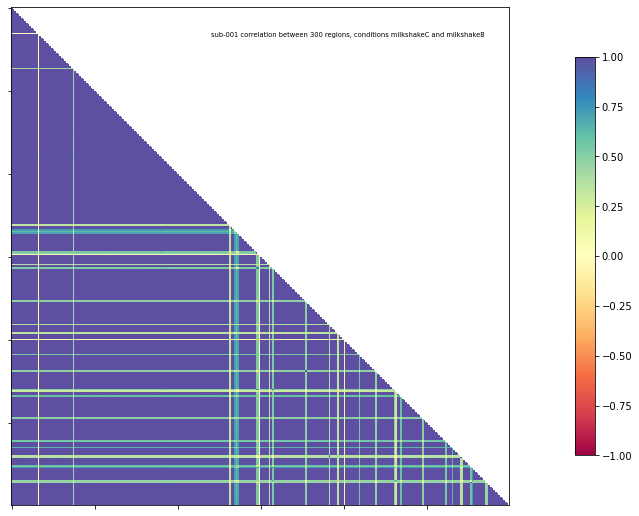


[INFO] sub-004 correlation between 300 regions, conditions milkshakeB and milkshakeA


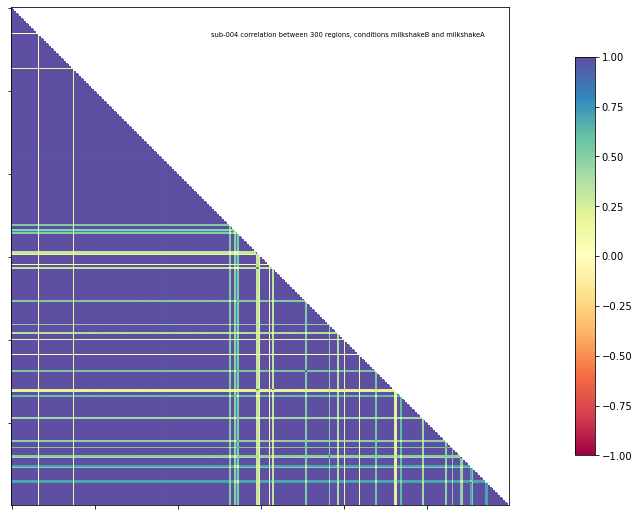


[INFO] sub-022 correlation between 300 regions, conditions milkshakeD and milkshakeC


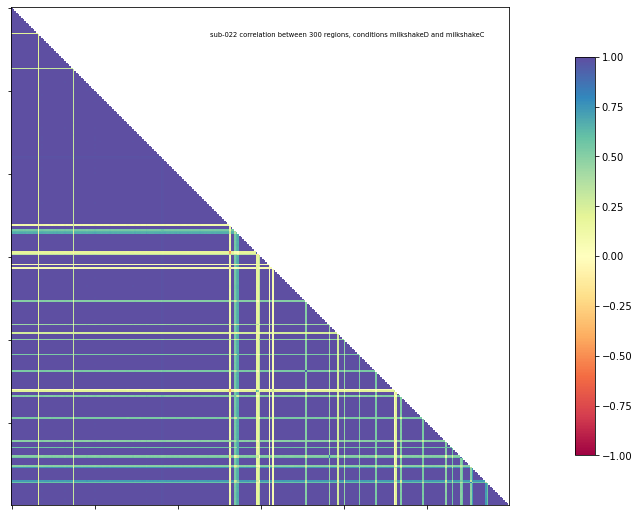


[INFO] sub-027 correlation between 300 regions, conditions milkshakeB and milkshakeA


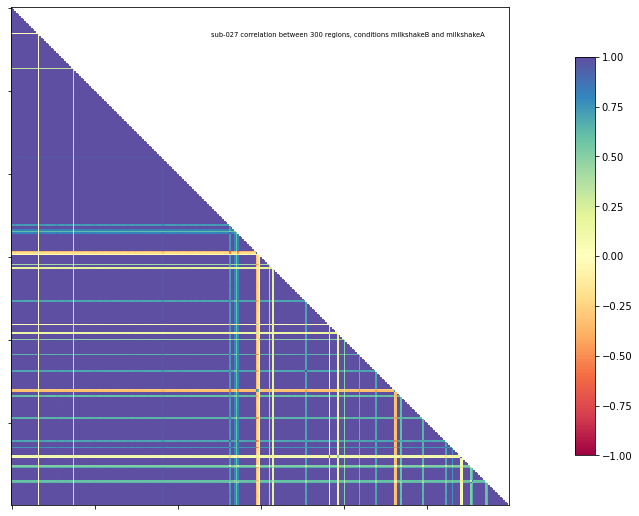


[INFO] sub-037 correlation between 300 regions, conditions milkshakeD and milkshakeB


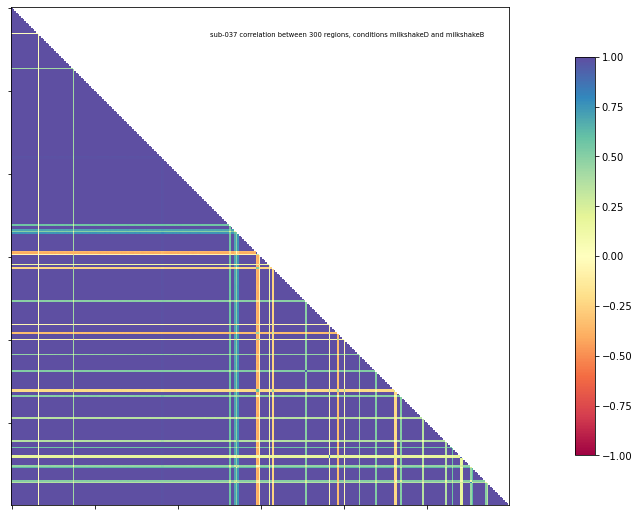


[INFO] sub-039 correlation between 300 regions, conditions milkshakeC and milkshakeA


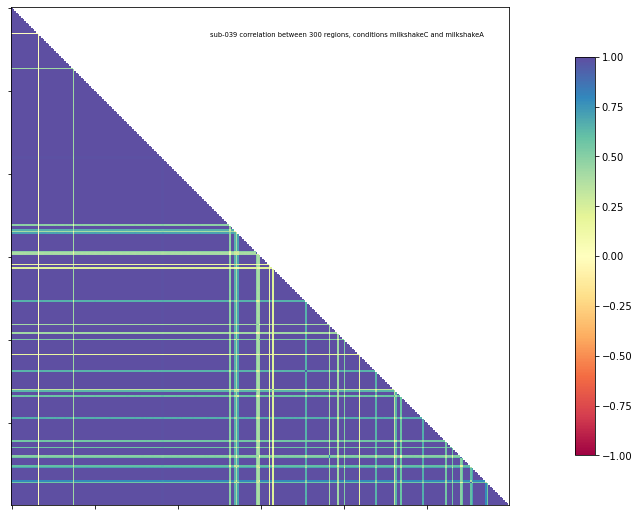


[INFO] sub-046 correlation between 300 regions, conditions milkshakeD and milkshakeA


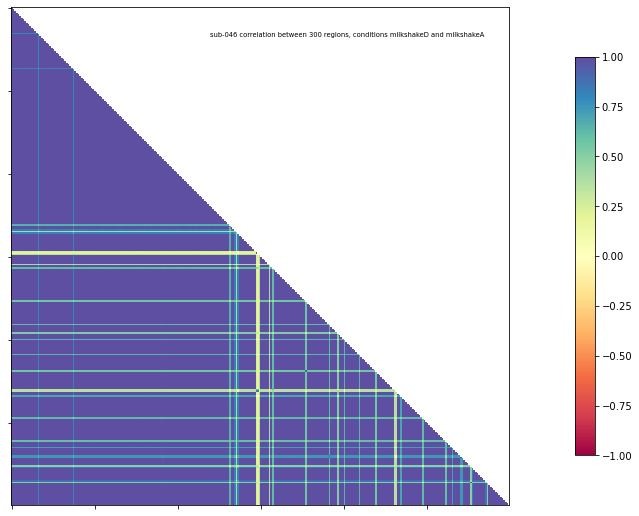


[INFO] sub-047 correlation between 300 regions, conditions milkshakeB and milkshakeA


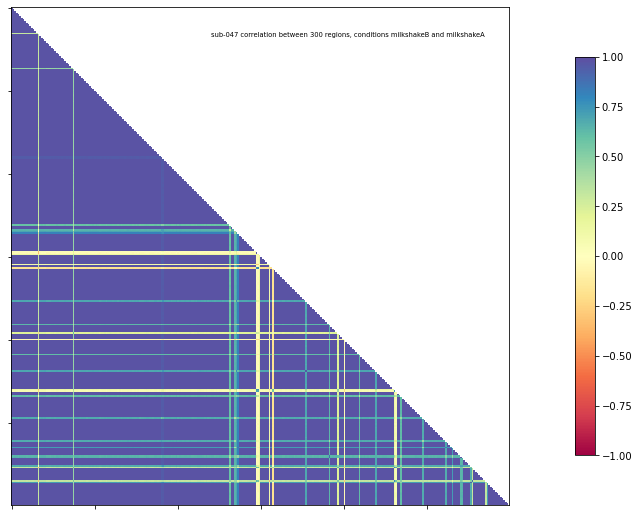


[INFO] sub-055 correlation between 300 regions, conditions milkshakeD and milkshakeA


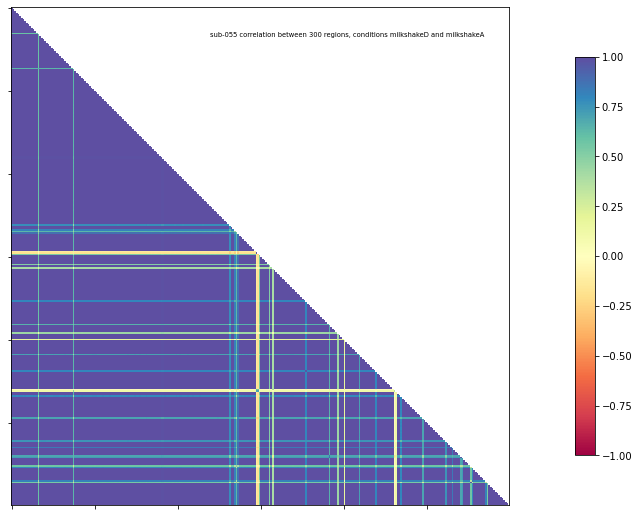


[INFO] sub-056 correlation between 300 regions, conditions milkshakeD and milkshakeC


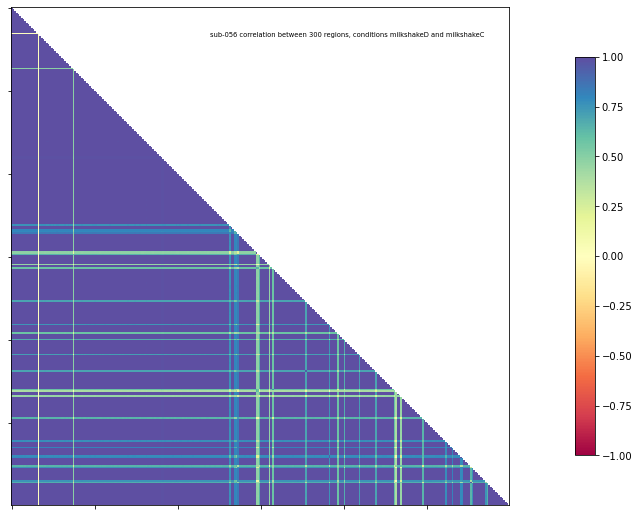


[INFO] sub-064 correlation between 300 regions, conditions milkshakeC and milkshakeA


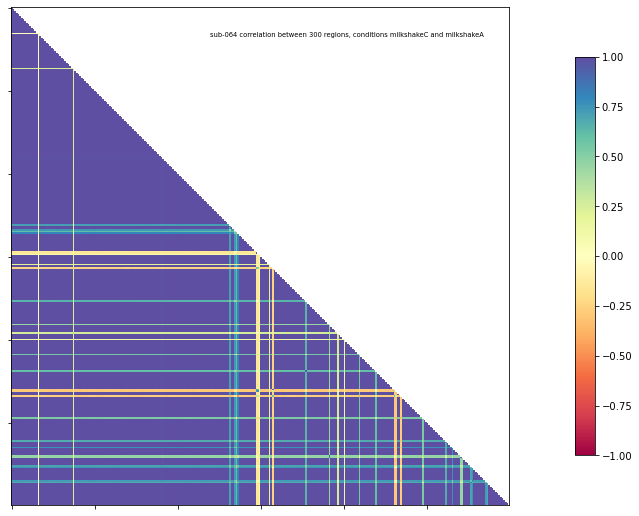


[INFO] sub-075 correlation between 300 regions, conditions milkshakeD and milkshakeB


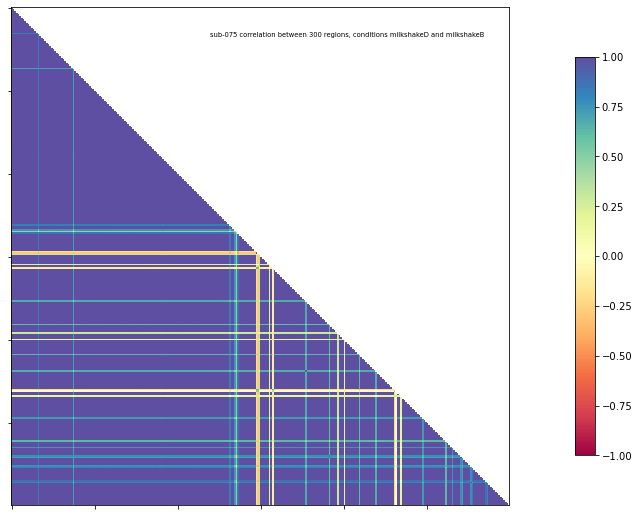


[INFO] sub-085 correlation between 300 regions, conditions milkshakeB and milkshakeA


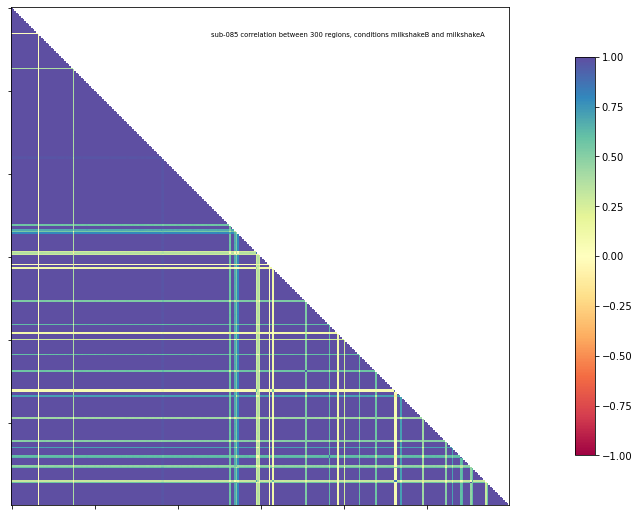


[INFO] sub-097 correlation between 300 regions, conditions milkshakeC and milkshakeB


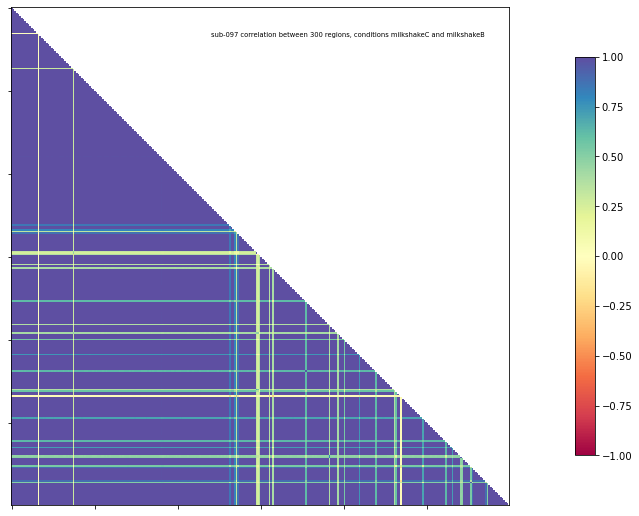


[INFO] sub-106 correlation between 300 regions, conditions milkshakeD and milkshakeA


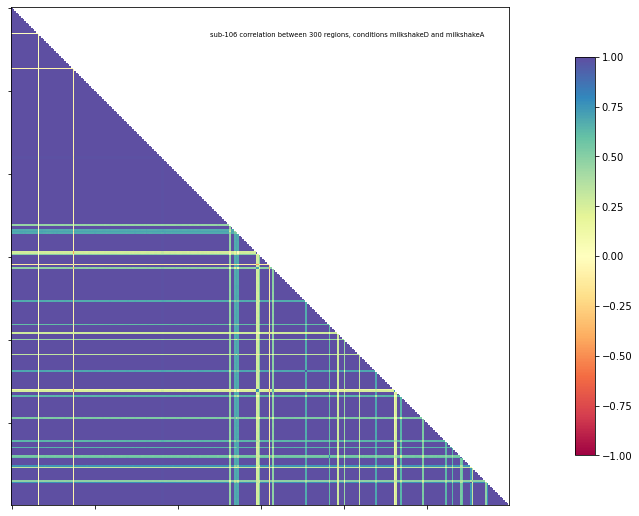


[INFO] sub-115 correlation between 300 regions, conditions milkshakeD and milkshakeC


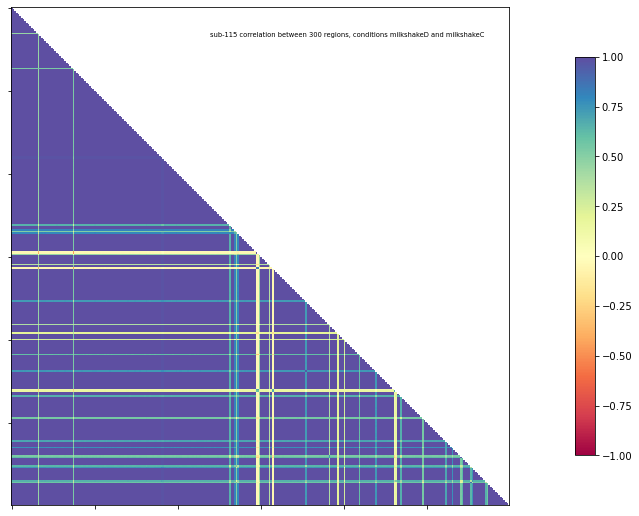


[INFO] sub-126 correlation between 300 regions, conditions milkshakeD and milkshakeB


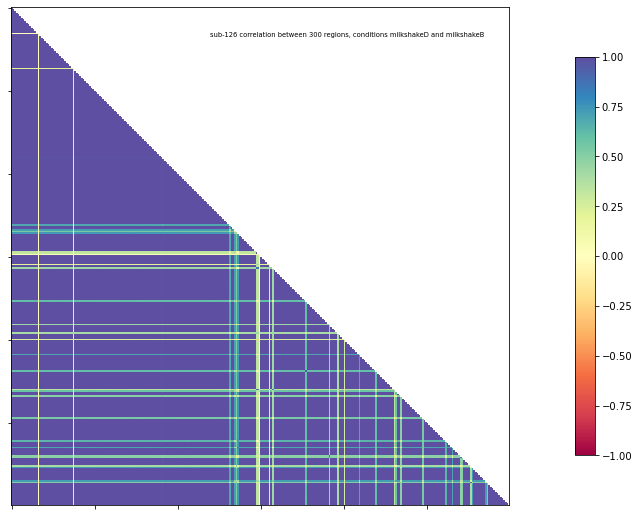


[INFO] sub-138 correlation between 300 regions, conditions milkshakeD and milkshakeB


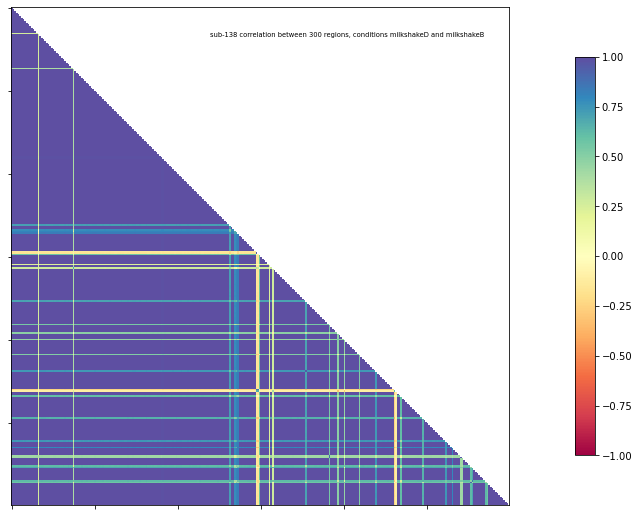


[INFO] sub-029 correlation between 300 regions, conditions milkshakeD and milkshakeA


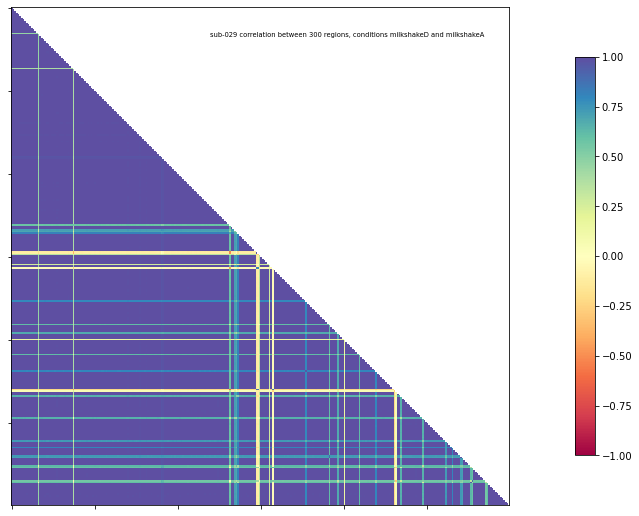


[INFO] sub-015 correlation between 300 regions, conditions milkshakeA and milkshakeC


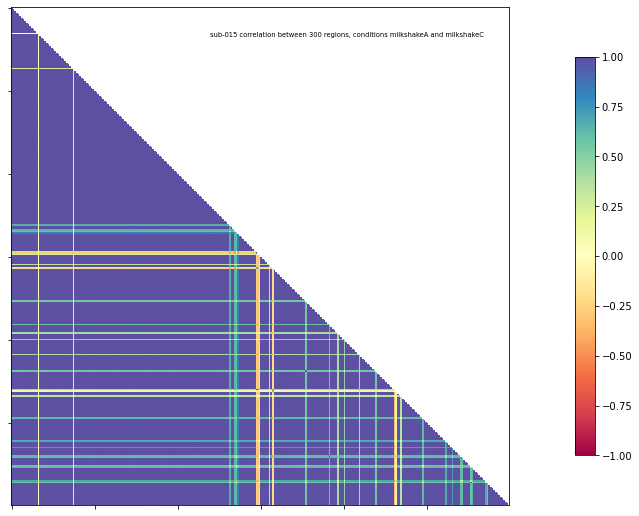


[INFO] sub-020 correlation between 300 regions, conditions milkshakeD and milkshakeC


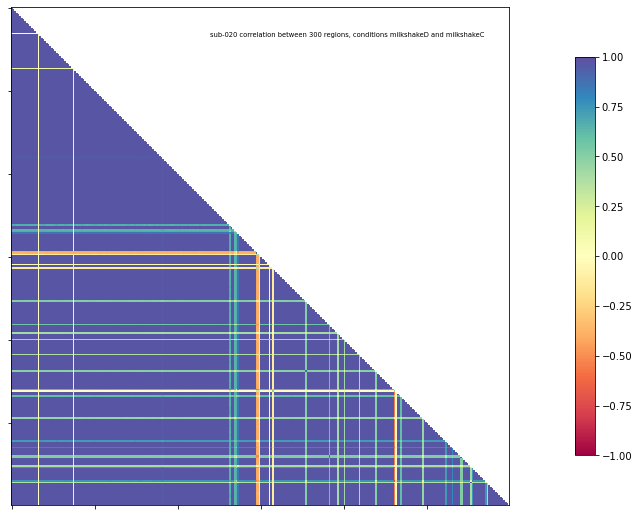


[INFO] sub-146 correlation between 300 regions, conditions milkshakeB and milkshakeA


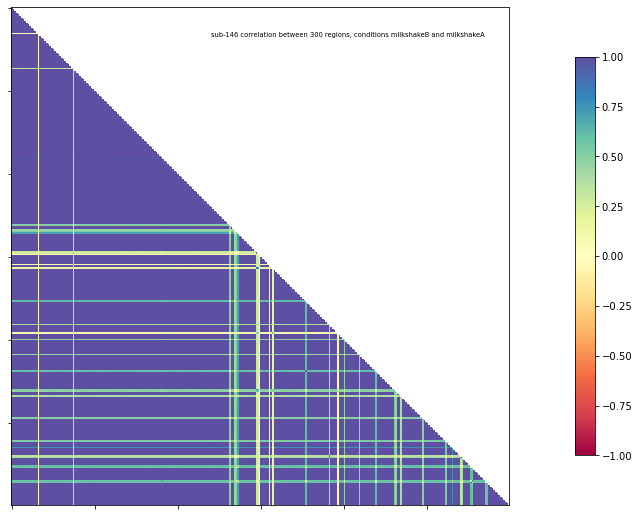

In [99]:
# loop through dictionary and make matrice for subject with 300 roi timeseries files
concat_sub_timeseries=False
make_fcms=True
fc_corr_dict = {}

for subject in list(data_dict.keys()):
    
    subj_list=[]
    bad_subjects=[]
    correlations = []
    n_regions_extracted=300

    for task in data_dict[subject].keys():
        if data_dict[subject][task]['bb300'] == 300:
            
            # concat subjects
            if concat_sub_timeseries==True:
                timeseries_concat(subject, task)
                
            # make fcms
            if make_fcms==True:
                cmap="Spectral"
                timeseries_files=glob.glob('/projects/niblab/experiments/chocolate_milkshake/data/subject_matrices/funcs_uc/sub-*_*.txt')

                # Initializing ConnectivityMeasure object with kind='correlation'
                connectome_measure = ConnectivityMeasure(kind='correlation')#, vectorize=True)
                
                # make subject & condition/task connectivtiy matrix
                make_subject_fcm(subject)
                
    if len(correlations) >= 2:
        task1=list(data_dict[subject].keys())[0].split("-")[1]
        task2=list(data_dict[subject].keys())[1].split("-")[1]

        #print("[INFO] making mean FCM for subject")                

        # make large subject matrix from average of the condition matrices
        mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted, n_regions_extracted)
        #print("[INFO] MEAN FCM: ", mean_correlations.shape)

        #print('[INFO] correlations: \n', mean_correlations)
        ## plotting
        #print('[INFO] Plot of the mean functional connectivity matrix: \n')
        title = '%s correlation between %d regions, conditions %s and %s'%(subject, 300, task1, task2)
        
        out_img=os.path.join(data_path, "fcms/heatmaps/%s_ses-1_task-%s-%s_heatmap.png"%(subject,task1, task2))
        out_avg_file=os.path.join(data_path, "fcms/matrices/%s_ses-1_task-%s-%s_avg.txt"%(subject, task1,task2))

        
        
        
        #print('[INFO] OUTFILE: \n%s \n%s'%(out_img, out_avg_file))
         # do I save the files?
        # save correlation as textfile
        #np.savetxt(out_avg_file, mean_correlations.transpose(2,0,1).reshape(3,-1))
        
        #print("[INFO] Outfile: {}".format(out_avg_file))

        # First plot the matrix
        print('\n[INFO] %s'%title)
        display1 = plotting.plot_matrix(mean_correlations,figure=(9, 7), vmax=1, vmin=-1,
                                       title=title, colorbar=True,
                                       cmap='Spectral', tri='lower')
        
        
        # We threshold to keep only the 20% of edges with the highest value
        # because the graph is very dense
        #display2 = plotting.plot_connectome(mean_correlations, coords_list,
                #edge_threshold="90%", title=title)


        display1.figure.savefig(out_img)

        plt.show() 
        
        
        






In [98]:
# test matrix saved correctly
#filex=glob.glob(os.path.join(data_path, "fcms/matrices/*"))[0]
#np.load(filex)

## Heatmap FCM  Widget Viewer <a class='anchor' id='fcmwidget'></a>

Run to quickly gather and sift through subjects

In [142]:
import matplotlib.image as mpimg
import ipywidgets as widgets
from IPython.display import display
from IPython.html.widgets import interactive
plt.rcParams["figure.figsize"] = (40,20)

In [172]:
def plot_fcm(subject_id):
    
    roi_matrices =glob.glob(os.path.join(data_path, 'subject_matrices/funcs_uc/%s*.txt'%subject_id))
    #print(roi_timeseries)
    for matrix in roi_matrices:
        filename = matrix.split("/")[-1] #"%s_ses-1_%s.txt"%(subj_id, task_id)
        #print("\n[INFO] Subject Matrix: %s "%filename)
        title_str=filename.split(".")[0]

        try:
            # we load the text file timeseries into an array 
            np_arr = np.loadtxt(matrix)
            #print(np_arr)


            # call fit_transform from ConnectivityMeasure object
            correlation_matrix = connectome_measure.fit_transform([np_arr])[0]
            #correlations.append(correlation)
            #print('[INFO] CORRELATION: ', correlation_matrix)

            # Mask out the major diagonal
            np.fill_diagonal(correlation_matrix, 0)
            # plot subject correlation matrix
            plotting.plot_matrix(correlation_matrix, cmap=cmap, colorbar=True,title=title_str, tri='lower')
            
            # We threshold to keep only the 20% of edges with the highest value
            # because the graph is very dense
            plotting.plot_connectome(correlation_matrix, coords_list, edge_threshold="90%", title=title_str)

            plotting.show()

            
        except:
            pass

In [173]:
subjects=list(data_dict.keys())
def plot_subject_fcm(x=subjects[0]):
    plot_fcm(x)

w = widgets.Select(options=subjects)
interactive(plot_subject_fcm, x=w)

interactive(children=(Select(description='x', options=('sub-001', 'sub-004', 'sub-005', 'sub-009', 'sub-011', …

In [138]:
plotting.show()
view = plotting.view_connectome(large_correlation_matrix, coords, edge_threshold='80%')

# In a Jupyter notebook, if ``view`` is the output of a cell, it will
# be displayed below the cell
view
